In [34]:
#Predict stock price in next day using linear regression
#Given prices for the last N days, we train a model, and predict for day N+1

import os
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import math
import time

from matplotlib import pyplot as plt
from datetime import date, datetime, time, timedelta
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline

In [35]:
#Setting input Parameters
test_size = 0.2
cv_size = 0.2
Nmax = 40

fontsize = 14
ticklabelsize =14

In [36]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['close'])):
        X_train = np.array(range(len(df['close'][i-N:i]))) 
        y_train = np.array(df['close'][i-N:i]) 
        X_train = X_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [37]:
df=pd.read_csv('VTI.csv', sep=',')

# Convert Date column to datetime
df.loc[:,'Date']=pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns=[str(x).lower().replace(' ','_') for x in df.columns]

# Get month of each sample
df['month']=df['date'].dt.month

#Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2019-02-28,143.649994,143.899994,143.320007,143.460007,140.748276,2275100,2
1,2019-03-01,144.380005,144.600006,143.500000,144.419998,141.690125,2985100,3
2,2019-03-04,145.000000,145.029999,142.419998,143.750000,141.032806,3555400,3
3,2019-03-05,143.809998,143.899994,143.179993,143.479996,140.767883,2838000,3
4,2019-03-06,143.520004,143.550003,142.229996,142.389999,139.698502,2139600,3


Text(0, 0.5, 'close_in_USD')

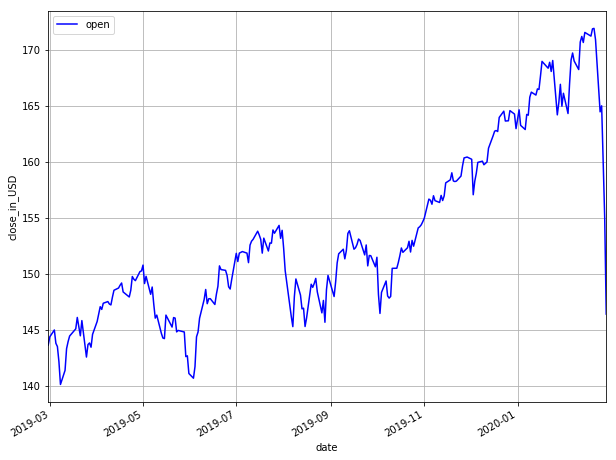

In [38]:
rcParams['figure.figsize']= 10, 8
ax=df.plot(x='date', y='open', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("close_in_USD")

In [39]:
# Get sizes of each datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train=df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 153
num_cv = 50
num_test = 50
train.shape = (153, 8)
cv.shape = (50, 8)
train_cv.shape = (203, 8)
test.shape = (50, 8)


Text(0, 0.5, 'USD')

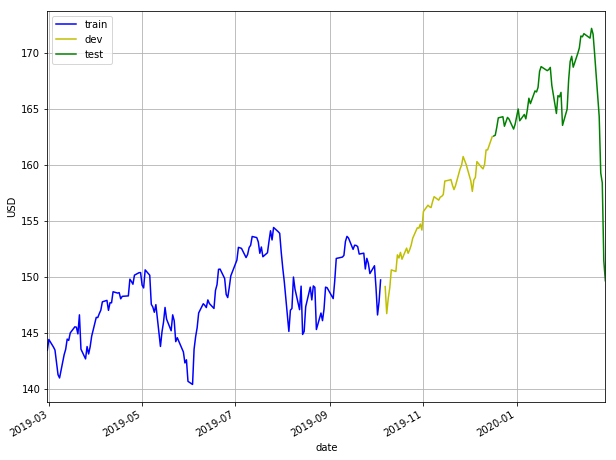

In [40]:
#Exploratory Data Analysis

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax=train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [41]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    R2.append(r2_score(cv['adj_close'], est_list))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [0.9995510092721821, 1.4796962633001902, 1.4004544562162569, 1.4346486152725524, 1.3722704128480954, 1.3246824583010988, 1.2843799027295972, 1.25609160949866, 1.2315119994276598, 1.2405596854327332, 1.2669052327741503, 1.2972620369779198, 1.3171646570010258, 1.338340231638066, 1.3582696722356242, 1.3803362389519116, 1.3949967743852971, 1.406362848685558, 1.421753926599506, 1.4574547666577957, 1.496242570198752, 1.5328080811430247, 1.568503248215678, 1.6158813678712496, 1.6660664687055502, 1.712179760483295, 1.7594283575369347, 1.810573157666848, 1.8631285555824457, 1.915347734111735, 1.959948215828375, 1.9872895163766302, 2.0053931897068282, 2.0151672773803537, 2.0279664697025517, 2.0489068286585685, 2.080166989746173, 2.103355534403091, 2.1175357344444246, 2.121959904106416]
R2 = [0.9311153731648778, 0.8490415109898517, 0.8647770626149572, 0.8580931130213512, 0.8701649990345274, 0.87901376647741, 0.8862636233224663, 0.8912185069678631, 0.8954341958575539, 0.8938921014347228, 0.

,date,open,high,low,close,adj_close,volume,month,est_N1,est_N2,...,est_N31,est_N32,est_N33,est_N34,est_N35,est_N36,est_N37,est_N38,est_N39,est_N40
153,2019-10-07,149.380005,150.190002,148.889999,149.139999,148.335693,2237400,10,149.729996,151.659989,...,151.611162,151.602924,151.666876,151.649733,151.730219,151.917144,152.088560,152.005065,152.033901,151.961540
154,2019-10-08,148.039993,148.360001,146.710007,146.729996,145.938690,2213900,10,149.139999,148.550002,...,151.366259,151.381734,151.383106,151.453958,151.445799,151.532017,151.721667,151.896473,151.823078,151.858539
155,2019-10-09,147.850006,148.589996,147.520004,148.080002,147.281418,3294600,10,146.729996,144.319993,...,150.543097,150.850746,150.883314,150.901230,150.985698,150.992762,151.090811,151.289133,151.472929,151.414616
156,2019-10-10,148.000000,149.500000,147.990005,149.029999,148.226288,3508900,10,148.080002,149.430008,...,149.989291,150.244920,150.552576,150.594064,150.620891,150.711969,150.727568,150.831324,151.032686,151.220116
157,2019-10-11,150.509995,151.899994,150.470001,150.630005,149.817673,3377100,10,149.029999,149.979996,...,149.501420,149.841855,150.093371,150.396310,150.441731,150.472778,150.566171,150.586145,150.691822,150.892770


(1, 30)

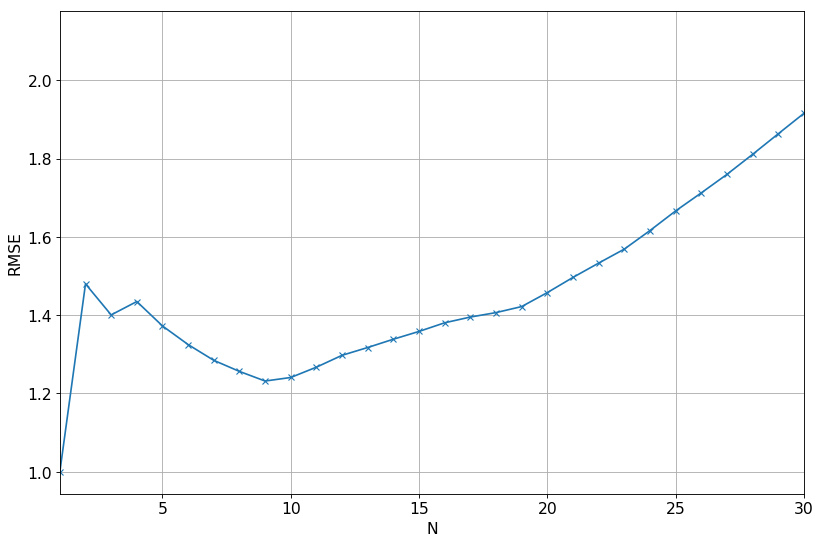

In [42]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([1, 30])

Text(0, 0.5, 'R2')

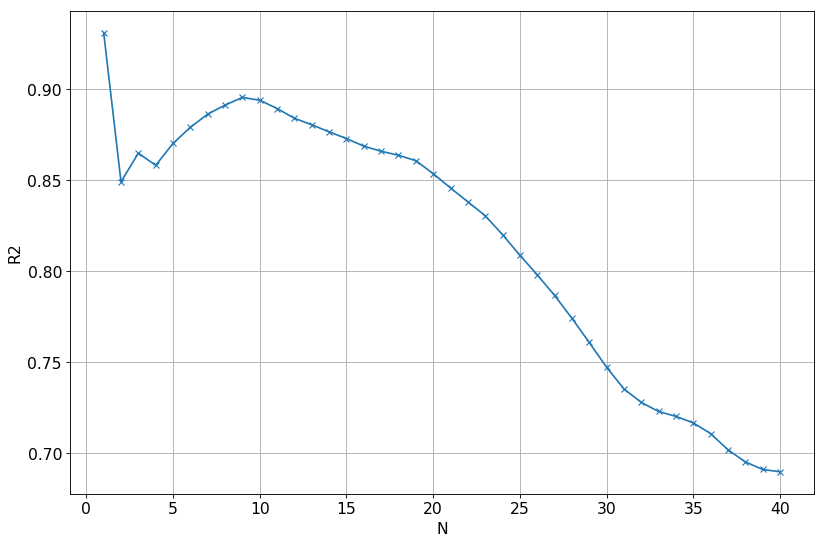

In [43]:
#Lowest RMSE is achieved for N=9

# Plot R2 versus N. Note for R2 larger better. 
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

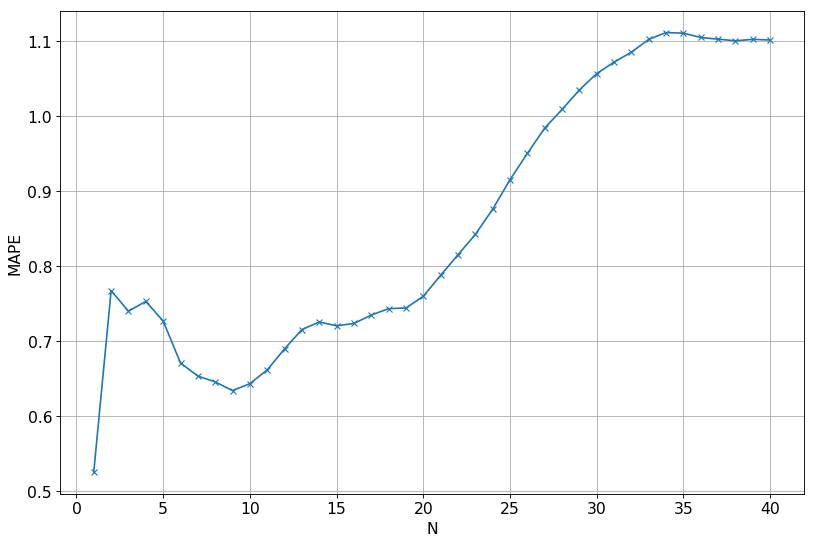

In [44]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1),mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [45]:
#Set N opt
N_opt=9

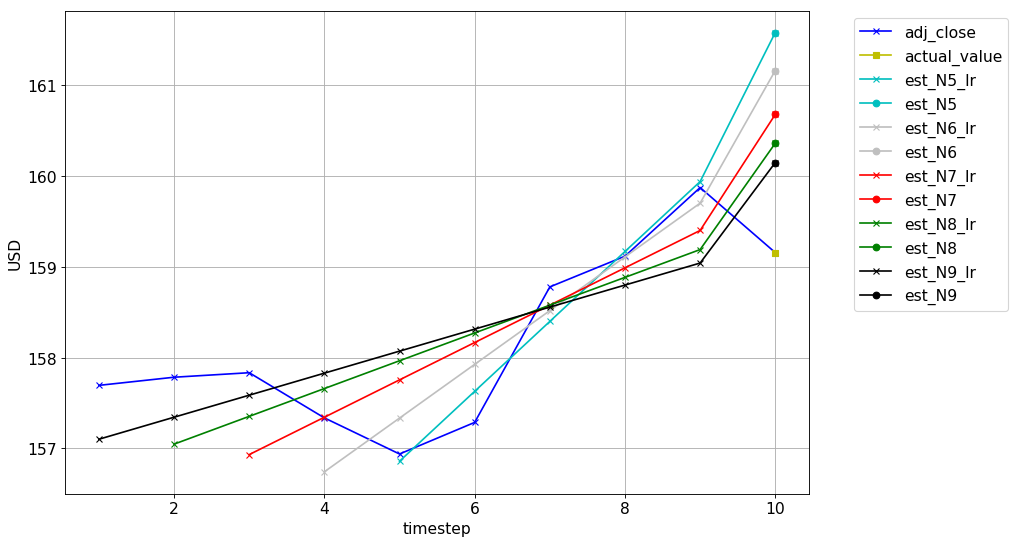

In [46]:
#Plotting predictions for a specific day

# Specifying the day we are interested in
day=pd.Timestamp(date(2019,11,30))

# Specify the maximum N we want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 9


df_temp = cv[cv['date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['adj_close'], 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['adj_close'], 'ys-')
legend_list = ['adj_close', 'actual_value']

# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(5, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['adj_close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['adj_close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})


Text(0, 0.5, 'USD')

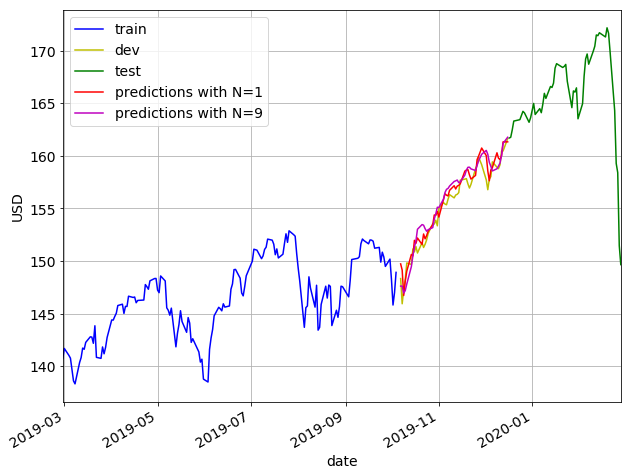

In [47]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N9', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=9'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

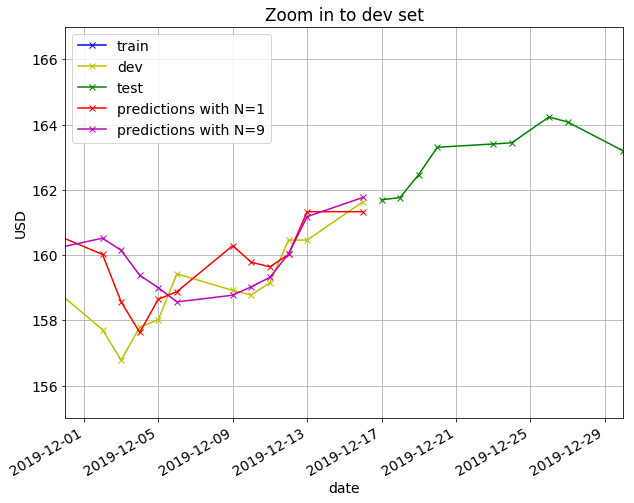

In [53]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N9', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=9'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 11, 30), date(2019, 12, 30)])
ax.set_ylim([155, 167])
ax.set_title('Zoom in to dev set')

In [54]:
est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("R2 = %0.3f" % r2_score(test['adj_close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 2.510
R2 = 0.685
MAPE = 0.968%


,date,open,high,low,close,adj_close,volume,month,est_N9
203,2019-12-17,162.770004,162.860001,162.440002,162.570007,161.693283,4421500,12,162.362501
204,2019-12-18,162.830002,162.919998,162.259995,162.639999,161.762894,2139800,12,162.889725
205,2019-12-19,162.740005,163.350006,162.699997,163.350006,162.469070,3018600,12,163.191670
206,2019-12-20,164.000000,164.339996,163.860001,164.190002,163.304535,3142900,12,163.926670
207,2019-12-23,164.559998,164.589996,164.199997,164.289993,163.403992,3822900,12,164.624170


Text(0, 0.5, 'USD')

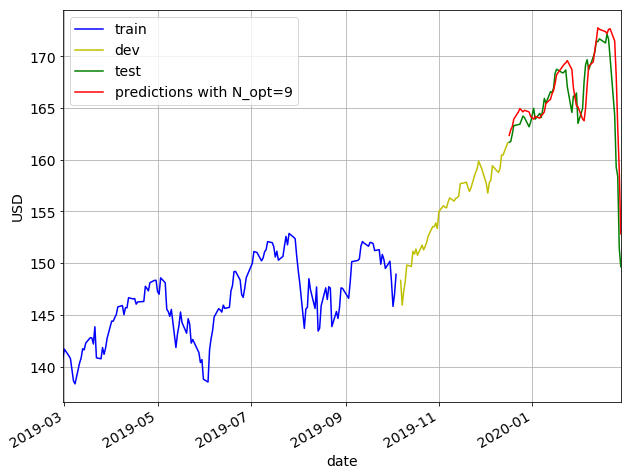

In [56]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N9', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=9'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

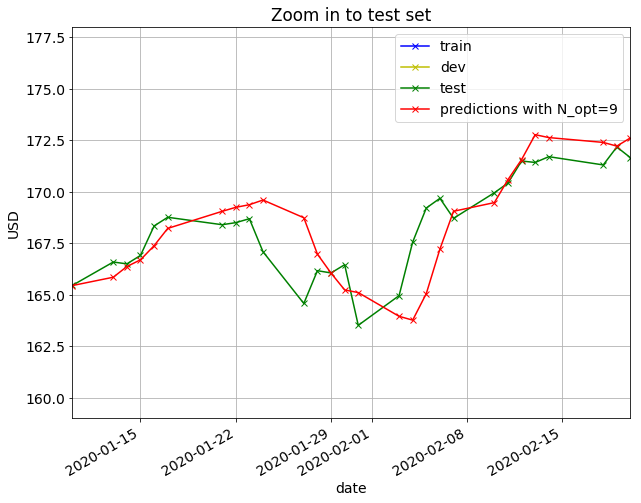

In [61]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N9', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=9'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 1, 10), date(2020, 2, 20)])
ax.set_ylim([159, 178])
ax.set_title('Zoom in to test set')

(160, 175)

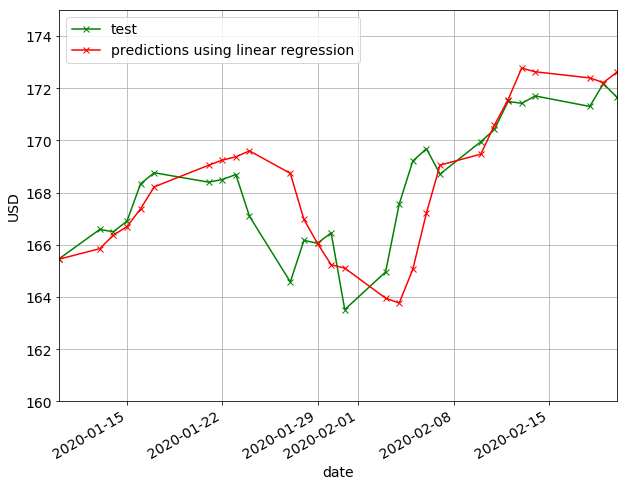

In [65]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N9', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 1, 10), date(2020, 2, 20)])
ax.set_ylim([160, 175])

In [66]:
# Save as csv
test_lin_reg = test
test_lin_reg.to_csv("test_lin_reg.csv")